In [1]:
import os
import pathlib
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from shutil import move
from IPython.display import clear_output
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
assert(tf.test.gpu_device_name())
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True) # Enable XLA.

In [ ]:
# # Preprocess the dataset
# size = (200,200)
# path = 'C:/Users/duboisrouvray/Documents/Entrainement_ML/Defect_detection/3D_defects/'
# for folder in os.listdir(path) :
#     for i, file in enumerate(glob.iglob(os.path.join(path + folder, "*.jpg"))) :
#         img = Image.open(r'{}'.format(file))
#         img.resize(size).convert('RGB').save('{}'.format(file))

In [24]:
# size = (200,200)
# nb_files_defected=0
# nb_files_no_defected=0
# path = 'C:/Users/duboisrouvray/Documents/Entrainement_ML/Defect_detection/3D_defects/'
# for i, file in enumerate(glob.iglob(os.path.join(path+'defected', "*.jpg"))) :
#     nb_files_defected+=1
#     if i > 700 :
#         move(file, path+'test/defected')
# for i, file in enumerate(glob.iglob(os.path.join(path+'no_defected', "*.jpg"))) :
#     nb_files_no_defected+=1
#     if i > 700 :
#         move(file, path+'test/no_defected')

# print(nb_files_defected, nb_files_no_defected)

759 798


In [22]:
CP_F = 0
learning_rate = 0.001
epochs = 20
init_threshold = 0.5
n_classes = 12
image_height = 200
image_width = image_height
n_channel = 3
batch_size = 2

data_dir_train = pathlib.Path('C:/Users/duboisrouvray/Documents/Entrainement_ML/Defect_detection/3D_defects/train')

train_dataset = image_dataset_from_directory(
    directory = data_dir_train,
    subset = "training",
    shuffle = True,
    validation_split = 0.2,
    seed=42,
    batch_size = batch_size,
    image_size = (image_height, image_width)
)

validation_dataset = image_dataset_from_directory(
    directory = data_dir_train,
    subset = "validation",
    shuffle = True,
    validation_split = 0.2,
    seed=42,
    batch_size = batch_size,
    image_size = (image_height, image_width)
)

data_dir_test = pathlib.Path('C:/Users/duboisrouvray/Documents/Entrainement_ML/Defect_detection/3D_defects/test')

test_dataset = image_dataset_from_directory(
    directory = data_dir_test,
    shuffle = True,
    seed=42,
    image_size = (image_height, image_width)
)

Found 1400 files belonging to 2 classes.
Using 1120 files for training.
Found 1400 files belonging to 2 classes.
Using 280 files for validation.
Found 157 files belonging to 2 classes.


In [3]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [3]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

rescale = tf.keras.layers.Rescaling(1./127.5, offset = -1)
inputs = tf.keras.Input(shape=(200, 200, 3))
model = tf.keras.Sequential([
    tf.keras.Input(shape=(200, 200, 3)),
    data_augmentation,
    rescale,
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'softmax'),
    ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                  

In [5]:
if (CP_F) :
    checkpoint_path = "C:/Users/duboisrouvray/Documents/Entrainement_ML/checkpoints_Wonders/weights.04-0.6463.cpkt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    model.load_weights(checkpoint_path)

earlystop_callback = EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="C:/Users/duboisrouvray/Documents/Entrainement_ML/checkpoints_Wonders/weights.{epoch:02d}-{val_accuracy:.4f}.cpkt",
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 mode='max',
                                                 initial_value_threshold = init_threshold,
                                                 verbose=1)

In [6]:
learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy'])

history = model.fit(train_dataset,
                    epochs= epochs,
                    validation_data = validation_dataset,
                    callbacks=[cp_callback, earlystop_callback])


Epoch 1/20
560/560 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.7437
Epoch 1: val_accuracy improved from 0.50000 to 0.82500, saving model to C:/Users/duboisrouvray/Documents/Entrainement_ML/checkpoints_Wonders\weights.01-0.8250.cpkt
560/560 [==============================] - 28s 50ms/step - loss: 0.5275 - accuracy: 0.7437 - val_loss: 0.3562 - val_accuracy: 0.8250
Epoch 2/20
560/560 [==============================] - ETA: 0s - loss: 0.3802 - accuracy: 0.8482
Epoch 2: val_accuracy improved from 0.82500 to 0.88929, saving model to C:/Users/duboisrouvray/Documents/Entrainement_ML/checkpoints_Wonders\weights.02-0.8893.cpkt
560/560 [==============================] - 26s 47ms/step - loss: 0.3802 - accuracy: 0.8482 - val_loss: 0.2745 - val_accuracy: 0.8893
Epoch 3/20
559/560 [============================>.] - ETA: 0s - loss: 0.3602 - accuracy: 0.8569
Epoch 3: val_accuracy did not improve from 0.88929
560/560 [==============================] - 27s 48ms/step - loss: 0.

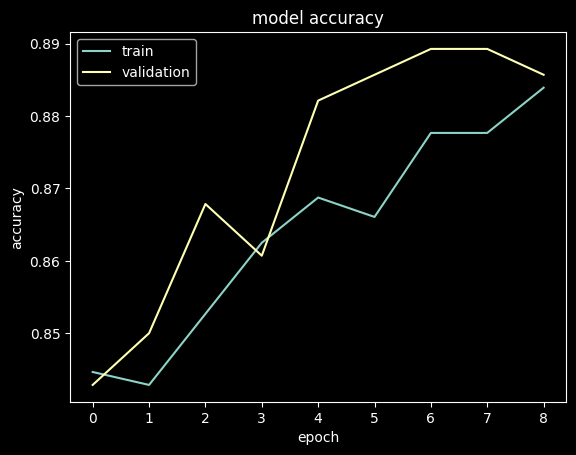

In [25]:
plt.style.use('dark_background')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [7]:
scores = model.evaluate(test_dataset, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100)) 

79/79 [==============================] - 1s 14ms/step - loss: 0.5501 - accuracy: 0.6815
accuracy: 68.15%


[[0.05605319 0.94394684]
 [0.9590217  0.04097832]]
{0: 1, 1: 0}
Predictions:
 {0: 1, 1: 0}
Labels:
 [1 0]


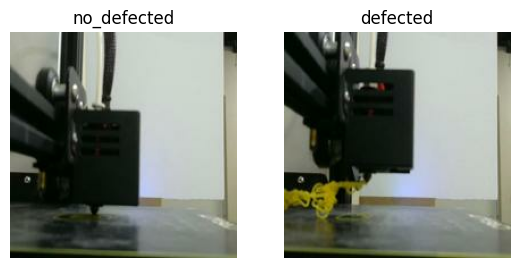

In [9]:
# Retrieve a batch of images from the test set
class_names = ['defected', 'no_defected']
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print(predictions)
predictions = model.predict_on_batch(image_batch).flatten()
n = 0
results = {}
for i in range(0,2) :
  if  (max(predictions[n], predictions[n+1]) == predictions[n]) :
    results[i] = 0
  if (max(predictions[n], predictions[n+1]) == predictions[n+1]) :
    results[i] = 1
  n += 2 
print(results)

print('Predictions:\n', results)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(2):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[results[i]])
  plt.axis("off")

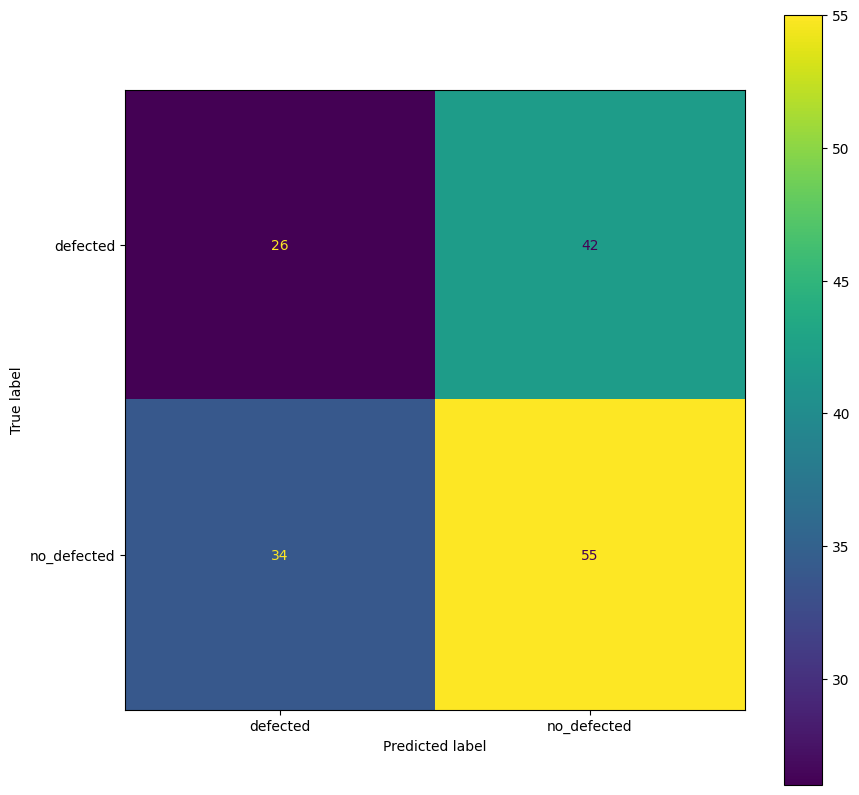

In [10]:
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
#Make predictions
y_probs = model.predict(test_dataset)
#Convert prediction probabilities into integers
y_preds = y_probs.argmax(axis=1)
y_labels = np.concatenate([y for x, y in test_dataset], axis=0)
#Confusion matrix
cm=confusion_matrix(y_preds,y_labels)
#Plot
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [14]:
import random
def plot_random_image(model,images, true_labels, classes):

    plt.figure(figsize=(10,15))

    for i in range(12):
        ax=plt.subplot(4,3,i+1)
        rand_index=random.choice(range(len(images)))

        #Make prediction
        target_image=images[rand_index]
        pred_probs=model.predict(tf.expand_dims(target_image,axis=0))
        pred_label=classes[pred_probs.argmax()]
        true_label= classes[true_labels[rand_index]]
        plt.imshow(target_image.astype('uint8'))
        
        #Change the color of the titles
        if pred_label==true_label:
            color="green"
        else:
            color="red"

        plt.xlabel("Pred:{} {:2.0f}% \n(True:{})".format(pred_label,
                                             100*tf.reduce_max(pred_probs),
                                             true_label),
                                             color=color, fontsize=13
                                             )
        #Hide ticks
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)

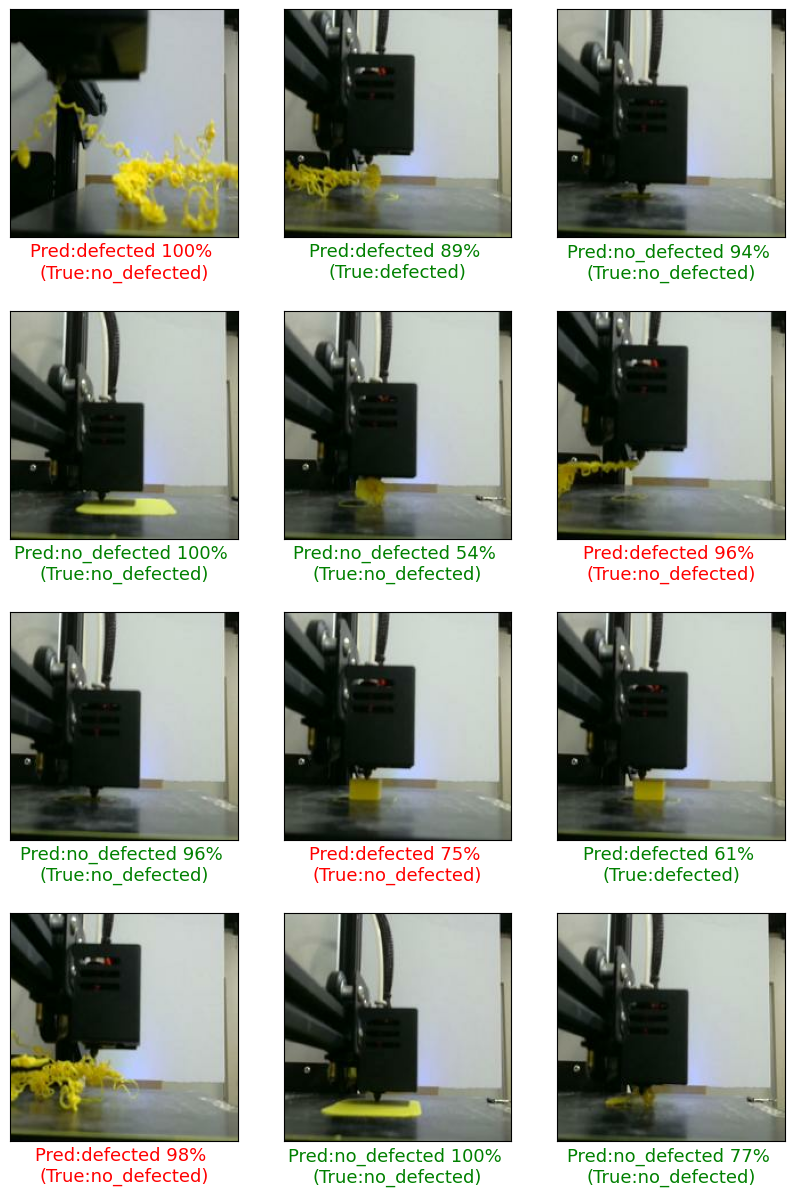

In [23]:
for images, labels in test_dataset.take(3):  # only take first element of dataset
    numpy_images = images.numpy()
plot_random_image(model, numpy_images, y_labels, class_names)